# Creating computer vision models for image classification

<a href="https://colab.research.google.com/drive/1-0TkvCFAtmxnt8DOZVKDsTLw3fQa5Mb3" target="_blank">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab">
</a>

Return to the [castle](https://github.com/Nkluge-correa/TeenyTinyCastle).

In the ever-expanding realm of artificial intelligence, image classification stands as one of the most common tasks for what models are developed. Meanwhile, **convolutional neural networks** (`CNNs`) are a type of deep neural network commonly used in image, video, and audio recognition tasks, being the cornerstone within the domain of computer vision by mimicking the hierarchical structure of biological visual system.

`CNNs` are designed to automatically learn and extract features from continuous data through a series of convolutional layers, pooling layers, and fully connected layers. Convolutional layers use filters to convolve over the input and produce feature maps that capture the presence of certain patterns in the data. Meanwhile, pooling layers are used to down-sample the feature maps and reduce the dimensionality of the data, while fully connected layers are used to perform classification or regression tasks based on the extracted features.

> **Note: To learn more about the convolution operation, we recommend the following [article](https://github.com/christianversloot/machine-learning-articles/blob/main/convolutional-neural-networks-and-their-components-for-computer-vision.md) and this [video lesson](https://www.youtube.com/watch?v=py5byOOHZM8).**

At the heart of computer vision, you will find famous architectures like [MobileNet V2](https://huggingface.co/docs/transformers/model_doc/mobilenet_v2), [ResNet](https://huggingface.co/docs/transformers/model_doc/resnet), and [ViT](https://huggingface.co/docs/transformers/model_doc/vit), which are powerful CNNs, all having already pre-trained weights.

In this tutorial, we will train our own CNN using the `Keras` API and fine-tune an already pre-trained model, all on the `CIFAR-10` dataset.

> **Note:** Later you can use this model to try some interpretability tools available in these notebooks: [feature visualization](https://github.com/Nkluge-correa/TeenyTinyCastle/blob/master/ML-Explainability/CV/CNN_feature_visualization.ipynb), [attribution maps](https://github.com/Nkluge-correa/TeenyTinyCastle/blob/master/ML-Explainability/CV/CNN_attribution_maps.ipynb), and [LIME](https://github.com/Nkluge-correa/TeenyTinyCastle/blob/master/ML-Explainability/CV/CNN_attribution_maps_with_LIME.ipynb).

![image](https://storage.googleapis.com/kaggle-media/competitions/kaggle/3649/media/cifar-10.png)

[Source](https://www.kaggle.com/c/cifar-10/).

The `CIFAR-10` dataset ([Canadian Institute For Advanced Research](https://en.wikipedia.org/wiki/Canadian_Institute_for_Advanced_Research)) is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research. It contains 60,000 32x32 color images in 10 different classes. The 10 different classes are `['airplanes', 'cars', 'birds', 'cats', 'deer', 'dogs', 'frogs', 'horses', 'ships', 'trucks']`. There are 6,000 images of each class.

>  **Note:** This dataset was introduced in the paper "_[Learning Multiple Layers of Features from Tiny Images](https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf)_."

For starters, let us download our dataset. We can import the dataset directly from TensorFlow for our first CNN network.

170498071/170498071 [==============================] - 2s 0us/step


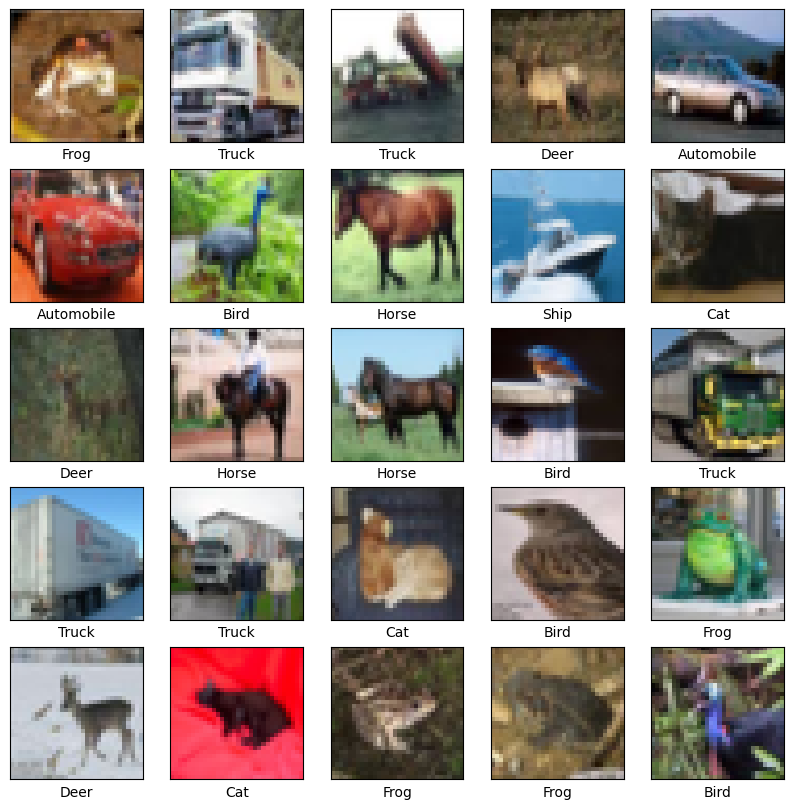

In [34]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Load the CIFAR 10 dataset
(train_images, train_labels), (test_images,
                               test_labels) = tf.keras.datasets.cifar10.load_data()

# Classes names
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
               'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Plot a 5 by 5 matrix of examples form CIFAR 10
plt.figure(figsize=[10, 10])
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i][0]])

plt.show()


The `CIFAR-10` dataset initially contains images with pixel values from 0 to 255. However, normalizing these pixel values between 0 and 1 before training is a common preprocessing step that helps improve the training process's stability and convergence. Normalization (like layer normalization or batch normalization) generally allows us to train over parameterized networks efficiently in deep learning.

> **Note:** You can learn more about normalizations technique here ([Layer Normalization](https://paperswithcode.com/method/layer-normalization)) and here ([Batch Normalization](https://paperswithcode.com/method/batch-normalization)).

In [35]:
# Converting numerical types to float32
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

# Normalizing the images
train_images = train_images / 255.
test_images = test_images / 255.

# Creating categorical labels (one-hot-vectors)
num_classes = 10
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes)

print("Training samples: ", train_images.shape)
print("Test samples: ", test_images.shape)
print("Training Labels: ", train_labels.shape)
print("Test Labels: ", test_labels.shape)

Training samples:  (50000, 32, 32, 3)
Test samples:  (10000, 32, 32, 3)
Training Labels:  (50000, 10)
Test Labels:  (10000, 10)


Now, to our model. The architecture design below is generic and can be reutilized for other classification problems. Here are its building blocks:

- A [`Conv2D`](https://paperswithcode.com/methods/category/convolutional-neural-networks) layer is a fundamental building block of a `CNN`. It performs a convolution operation on the input data, typically an image, to extract features and patterns relevant to the task at hand. The `Conv2D` layer comprises a set of learnable filters, or kernels, applied to the input data. Each filter is a small matrix that slides over the input data, computing the dot product between the filter and the overlapping region of the input. This produces a 2D feature map representing the filter's response at each location in the input. The layer then combines all the filters' feature maps to create a new output tensor. To learn more about `convolution layers`, read "_[Neocognitron: A Self-organizing Neural Network Model for a Mechanism of Pattern Recognition Unaffected by Shift in Position](https://www.rctn.org/bruno/public/papers/Fukushima1980.pdf)_."

- Batch normalization is a technique used in deep learning to improve the performance and stability of neural networks. The [`BatchNormalization`](https://paperswithcode.com/method/batch-normalization) layer is a type of layer that implements this technique. During training, the input data to a neural network can have different distributions for each mini-batch, making it difficult to train the network. Batch normalization addresses this problem by normalizing the input to each layer so that it has a mean of 0 and a variance of 1.

- The [`MaxPooling2D`](https://paperswithcode.com/method/max-pooling) layer operates on a 2D input tensor, typically the output of a `Conv2D` layer. It applies a max pooling operation to the input, which involves dividing the input into rectangular regions and taking the maximum value within each region. The result is a downsampled version of the input that preserves the most important features of the image while reducing its spatial dimensions.

- The [`Dropout`](https://paperswithcode.com/method/dropout) layer randomly drops out (or "turns off") a fraction of a layer's input units during each training iteration. This means that the weights of those dropped-out units need to be updated during that iteration, which can help prevent the network from relying too heavily on any one feature or combination of features.

Below, we are staking our layers using the `Sequential` API from `Keras`. We use [Adam](https://paperswithcode.com/method/adam) as our optimizer and categorical cross-entropy as our loss function.

In [ ]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(32, (3, 3), padding='same',
          activation='relu', input_shape=(32, 32, 3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

model.summary()


But you can also try a CNN with a different architecture and convolution layer, like Depthwise Separable Convolutions (`SeparableConv2D`).

> **Note: To learn more about `depthwise separable convolutions`, read "_[Xception: Deep Learning with Depthwise Separable Convolutions](https://arxiv.org/abs/1610.02357)_", our check this other [tutorial](https://github.com/Nkluge-correa/TeenyTinyCastle/blob/master/ML-Accountability/CO2-Emission-tracking/carbon_emission_cv.ipynb).**

Now, let us train our CNN. We are going to be using three different callbacks to help us with our training:

- `ModelCheckpoint`: used to save the weights of the best-performing model during training. It allows the user to specify the metric to monitor and the frequency at which the weights should be saved.
- `ReduceLROnPlateau`: used to reduce the learning rate of the optimizer if the model's performance on a validation set stops improving. This can help the model converge faster and can prevent the model from getting stuck in local optima.
- `EarlyStopping`: used to stop the training process if the model's performance on a validation set stops improving for a specified number of epochs. This can help prevent overfitting and save time by stopping the training process early if the model is not improving.


In [ ]:
# Create a list of callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "Cifar_CNN_SeparableConv2D.keras",
            save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5),
    tf.keras.callbacks.EarlyStopping(
        monitor="categorical_accuracy",
        patience=10,
        verbose=2,
        mode="auto",
        baseline=None,
        restore_best_weights=True)
]

# Print the stats of your TF environment
print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

# Train your CNN!
model.fit(train_images, train_labels, batch_size=64, epochs=60,
                    validation_split=0.2, verbose=2, callbacks=callbacks)

# Evaluate your model
test_loss_score, test_acc_score = model.evaluate(test_images, test_labels)

print(f'Final Loss: {test_loss_score:.2f}.')
print(f'Final Performance: {test_acc_score * 100:.2f} %.')


Congratulations, you have trained your own CNN! This model is available on Hugging Face under the alias [Cifar-CNN](https://huggingface.co/AiresPucrs/Cifar-CNN). Other notebooks in our repo use this model, but you can download it straight from the Hub, as shown in the cell below.

Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

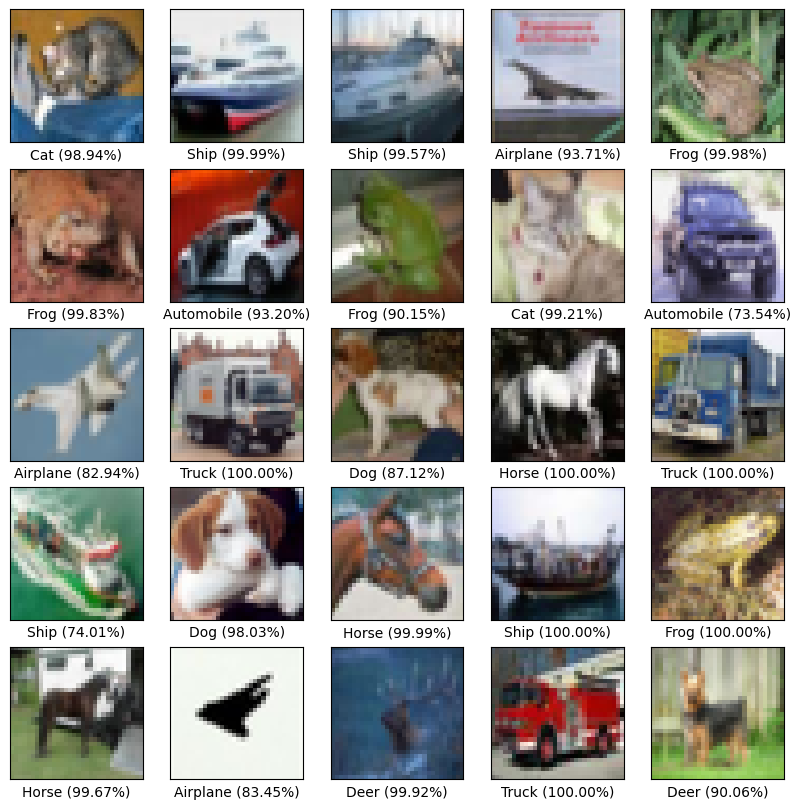

In [71]:
!pip install huggingface_hub["tensorflow"] -q

from huggingface_hub import from_pretrained_keras

# Load the model from the Hub
home_made_cnn = from_pretrained_keras("AiresPucrs/Cifar-CNN")

# Create predictions for the first 25 images in the test set
preds = home_made_cnn.predict(test_images[:25], verbose=0)

labels = [np.argmax(test_labels[i]) for i in range(len(preds))]
predictions = [np.argmax(preds[i]) for i in range(len(preds))]

# Plot the predictions
plt.figure(figsize=[10, 10])

for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i], cmap=plt.cm.binary)
    plt.xlabel(f"{class_names[predictions[i]]} ({preds[i].max() * 100:.2f}%)")

plt.show()

## Fine-tuning MobileNet V2 on CIFAR 10

Let us see if we can achieve better performance by using an already pre-trained model for this task. We will use the `Transformers`, `Datasets`, and `Evaluate` libraries, all tied to the Hugging Face ecosystem.

Hence, let us start by installing our libraries and loading our CIFAR 10 dataset again (now using the version available in the Hub).







In [1]:
!pip install transformers datasets evaluate accelerate -q

from datasets import load_dataset

dataset = load_dataset("cifar10")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.7 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Let us take a look at an example of our dataset:

In [2]:
dataset["train"][0]

{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
 'label': 0}

Each example in the dataset has: (1) an image in PIL (Python Imaging Library) format and (2) the label class of that image. If we ant to look at an image, we just need to call it in the terminal.

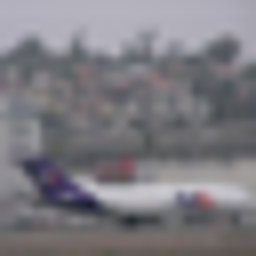

In [3]:
# Resize the image so you can see it is actually an airplane
display(dataset["train"][0]['img'].resize((256, 256)))

So we don't have to memorize that 0 = airplane and so on, let us just create a mapping of label to the class name.

In [4]:
# The dataset contains the names of the labels already!
labels = dataset["train"].features["label"].names

label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

display(label2id)
display(id2label)

{'airplane': '0',
 'automobile': '1',
 'bird': '2',
 'cat': '3',
 'deer': '4',
 'dog': '5',
 'frog': '6',
 'horse': '7',
 'ship': '8',
 'truck': '9'}

{'0': 'airplane',
 '1': 'automobile',
 '2': 'bird',
 '3': 'cat',
 '4': 'deer',
 '5': 'dog',
 '6': 'frog',
 '7': 'horse',
 '8': 'ship',
 '9': 'truck'}

Now, we need to process our images so that our model, which was not trained on 32 x 32 x 3 images, can process them. For this, we use the `AutoImageProcessor` class.

> **Note:** An image processor is responsible for preparing input features for vision models and post-processing their outputs. This includes transformations such as resizing, normalization, and conversion to PyTorch, TensorFlow, Flax, and Numpy tensors. It may also include model-specific post-processing, such as converting logits to segmentation masks. Learn more about it [here](https://huggingface.co/docs/transformers/main_classes/image_processor).

In [5]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor
from transformers import AutoImageProcessor

# Define the model we will use for this fine-tuning job
checkpoint = "google/mobilenet_v2_1.0_224"

# Load the corresponding `ImageProcessor`
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

# Define a normalization function
normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)

# Get the correct size for the images
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)

# Create a single composed transformation that crops, resizes, normalizes the images, and returns tensors.
_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

# Define a function to map our dataset
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["img"]]
    del examples["img"]
    return examples

dataset = dataset.with_transform(transforms)

# Try it out!
dataset['train'][0]['pixel_values']

preprocessor_config.json:   0%|          | 0.00/406 [00:00<?, ?B/s]

tensor([[[ 0.3804,  0.3804,  0.3804,  ...,  0.3804,  0.3804,  0.3804],
         [ 0.3804,  0.3804,  0.3804,  ...,  0.3804,  0.3804,  0.3804],
         [ 0.3804,  0.3804,  0.3804,  ...,  0.3804,  0.3804,  0.3804],
         ...,
         [-0.1137, -0.1137, -0.1137,  ..., -0.1686, -0.1686, -0.1686],
         [-0.1137, -0.1137, -0.1137,  ..., -0.1686, -0.1686, -0.1686],
         [-0.1137, -0.1137, -0.1137,  ..., -0.1686, -0.1686, -0.1686]],

        [[ 0.3647,  0.3647,  0.3647,  ...,  0.3647,  0.3647,  0.3647],
         [ 0.3647,  0.3647,  0.3647,  ...,  0.3647,  0.3647,  0.3647],
         [ 0.3647,  0.3647,  0.3647,  ...,  0.3647,  0.3647,  0.3647],
         ...,
         [-0.1294, -0.1294, -0.1294,  ..., -0.1765, -0.1765, -0.1765],
         [-0.1294, -0.1294, -0.1294,  ..., -0.1765, -0.1765, -0.1765],
         [-0.1294, -0.1294, -0.1294,  ..., -0.1765, -0.1765, -0.1765]],

        [[ 0.4667,  0.4667,  0.4667,  ...,  0.4510,  0.4510,  0.4510],
         [ 0.4667,  0.4667,  0.4667,  ...,  0

Perfect. We only need a DataCollator to generate batches of examples for our model.

We will also include a metric during training to evaluate our model's performance using the [`Evaluate`](https://huggingface.co/docs/evaluate/index) library. 🤗

In [6]:
from transformers import DefaultDataCollator
import numpy as np
import evaluate

# Create a DataCollator
data_collator = DefaultDataCollator()

# Define our performance metric
accuracy = evaluate.load("accuracy")

# This function will compute acc for us during training.
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

We are ready to train our model, a.k.a.  **MobileNet V2**. MobileNet V2 was pre-trained on ImageNet-1k at resolution 224x224, and it was introduced in "_[MobileNetV2: Inverted Residuals and Linear Bottlenecks](https://arxiv.org/abs/1801.04381)_".

> **Note: To learn more about this mode, read its [model card](https://huggingface.co/google/mobilenet_v2_1.0_224).**

Since we are using the `Transformers` library, we load MobileNet V2 with [`AutoModelForImageClassification`](https://huggingface.co/docs/transformers/model_doc/auto), while specifying the number of labels along with the number of expected labels, and the label mappings.

In [7]:
from transformers import AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True, # We set this true because the original model was trained on 1000 classes, but our task only requires 10.
)

config.json:   0%|          | 0.00/69.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/14.2M [00:00<?, ?B/s]

Some weights of MobileNetV2ForImageClassification were not initialized from the model checkpoint at google/mobilenet_v2_1.0_224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1001]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1001, 1280]) in the checkpoint and torch.Size([10, 1280]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


To fine-tune our model, we only need to stipulate the `TrainingArguments,` and thanks to the `Trainer` API, we only need to pass these arguments, together with our model, tokenizer, data collector, and evaluation functions, and `Transformers` does the rest.

The `TrainingArguments` object defines various settings and parameters for training a machine learning model. Here's an explanation for each argument in the provided code:

-  `output_dir`: Specifies the directory where model checkpoints and other outputs will be saved during training.

- `remove_unused_columns`: If set to True, columns not used during training will be removed from the dataset.

-  `evaluation_strategy`: Determines when to evaluate training. In this case, "epoch" means evaluation is done at the end of each training epoch.

-  `save_strategy`: Determines when to save model checkpoints. Here, "epoch" means saving checkpoints at the end of each training epoch.
    
-  `learning_rate`: Sets the initial learning rate for the optimizer. It controls the step size during optimization and influences how quickly the model adapts to the training data.
    
-  `per_device_train_batch_size`: Defines the number of training examples per batch processed on each device (GPU or CPU). Larger batch sizes can lead to faster training but may require more memory.
    
-  `per_device_eval_batch_size`: Similar to `per_device_train_batch_size`, but for evaluation (validation and test) datasets.
    
-  `num_train_epochs`: Specifies the number of times the entire training dataset is passed through the model during training.

- `warmup_ratio`: The ratio of training steps during which the learning rate will increase linearly.
    
-  `weight_decay`: Adds a regularization term to the loss function to prevent overfitting. It penalizes large weights in the model.

-  `load_best_model_at_end`: If set to True, the training process will load the best model checkpoint based on the evaluation metric at the end of training.
    
-  `push_to_hub`: If True, it enables pushing the trained model and associated files to the Hugging Face Model Hub, making it accessible to the community.

- `metric_for_best_model`: The metric used to determine the best model during training. In this case, it's "accuracy."
    
-  `hub_token`: A token required for authentication when pushing the model to the Hugging Face Model Hub.
    
-  `hub_model_id`: Specifies the unique identifier for the model on the Hugging Face Model Hub that the user has permission to push the model to.

The learn more about the `TrainingArguments` and `Trainer` classes, read the [documentation](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments).

> **Note: If you dont want to train this from scratch, you can download it from the Hub! 🤗**

In [ ]:
from transformers import TrainingArguments, Trainer

# Define training arguments
training_args = TrainingArguments(
    output_dir="checkpoints",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=10,
    warmup_ratio=0.1,
    weight_decay=0.01,
    load_best_model_at_end=True,
    push_to_hub=True,
    metric_for_best_model="accuracy",
    hub_token="your_token_here",
    hub_model_id="AiresPucrs/Mobilenet-v2-CIFAR-10"
)

# Define the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

# Train!
trainer.train()

Congratulations, you just fine-tuned MobileNet V2. Bellow, we are testing our model on some images.

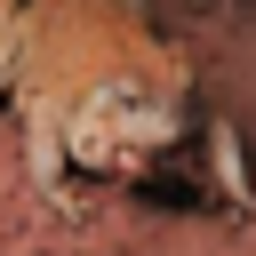

[{'score': 0.9993732571601868, 'label': 'frog'},
 {'score': 0.0004898000624962151, 'label': 'cat'},
 {'score': 0.0001227942411787808, 'label': 'dog'},
 {'score': 1.3917202522861771e-05, 'label': 'bird'},
 {'score': 1.6976893846276653e-07, 'label': 'deer'}]

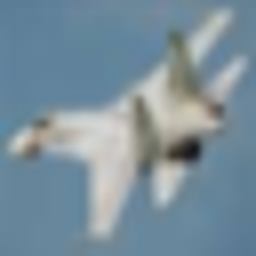

[{'score': 0.9962419271469116, 'label': 'airplane'},
 {'score': 0.0020448339637368917, 'label': 'cat'},
 {'score': 0.0004605802532751113, 'label': 'deer'},
 {'score': 0.00045690510887652636, 'label': 'horse'},
 {'score': 0.00036413653288036585, 'label': 'dog'}]

In [5]:
!pip install transformers datasets -q
from transformers import pipeline
from datasets import load_dataset

dataset = load_dataset("cifar10", split="test")

classifier = pipeline("image-classification", model="AiresPucrs/Mobilenet-v2-CIFAR-10")

display(dataset['img'][5].resize((256, 256)))
display(classifier(dataset['img'][5]))

display(dataset['img'][10].resize((256, 256)))
display(classifier(dataset['img'][10]))

We will use these models in some of our other tutorials in the Explainability folder.

> **Note: For more tutorials on image classification, visit the [Hub](https://huggingface.co/docs/transformers/tasks/image_classification).**

---

Return to the [castle](https://github.com/Nkluge-correa/TeenyTinyCastle).